In [4]:
from statistics import mean

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.optim as optim

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Introduction

Le fichier train.csv comprend un peu plus de 100 millions de lignes.  
Il y a un peu moins de 400 mille user_id uniques.  
Le modèle utilisé dans ce notebook prend en entrée une série par utilisateur.

# Features utilisées
Pour chaque question de la série d'apprentissage d'un utilisateur quelconque  

1. Question ID: correspond à content_id (lorsque l'élément est une question).
2. Question part: correspond à part dans question.csv pour l'élément dont question_id correspondant à content_id
3. Answer correctness: valeur de answered_correctly de l'exemple (ou target encoding de la question ?)
4. Current question elapsed time: prior question de la question suivante.
5. Timestamp difference: current question timestamp - timestamp of the last question from the same user

# Chargement des données

In [6]:
questions_df = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv', usecols=[0, 3])
questions_df

,question_id,part
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
13518,13518,5
13519,13519,5
13520,13520,5
13521,13521,5


In [7]:
data_types_dict={
    #'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    #'task_container_id': 'int16',
    #'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32', 
    #'prior_question_had_explanation': 'boolean',
    }

In [8]:
train = pd.read_csv('../input/riiid-test-answer-prediction/train.csv', usecols=data_types_dict.keys(), dtype=data_types_dict)[:1_000_000]#, skipfooter=90_000_000)
# skipfooter forces the use of the python engine which is much slower and too slow for this file.

In [9]:
train

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time
0,0,115,5692,0,1,NaN
1,56943,115,5716,0,1,37000.0
2,118363,115,128,0,1,55000.0
3,131167,115,7860,0,1,19000.0
4,137965,115,7922,0,1,11000.0
...,...,...,...,...,...,...
999995,26482248,20949024,8803,0,1,14000.0
999996,26516686,20949024,4664,0,1,17000.0
999997,26537967,20949024,4108,0,0,18000.0
999998,26590240,20949024,5014,0,0,6000.0


In [10]:
train = train[train.content_type_id == 0].drop('content_type_id', axis=1)

In [11]:
train = train.merge(questions_df, left_on="content_id", right_on="question_id").drop('content_id', axis=1)

In [12]:
train.sort_values(['user_id', 'timestamp'], inplace=True)

In [13]:
train

,timestamp,user_id,answered_correctly,prior_question_elapsed_time,question_id,part
0,0,115,1,NaN,5692,5
337,56943,115,1,37000.0,5716,5
579,118363,115,1,55000.0,128,1
760,131167,115,1,19000.0,7860,1
963,137965,115,1,11000.0,7922,1
...,...,...,...,...,...,...
207187,26482248,20949024,1,14000.0,8803,5
89100,26516686,20949024,1,17000.0,4664,5
86033,26537967,20949024,0,18000.0,4108,5
283089,26590240,20949024,0,6000.0,5014,5


# Construction des entrées et sorties

In [14]:
train.min() # on vérifie que le min est proche de 0 afin de ne pas perdre de place dans nn.embedding où les vecteurs sont alloués à partir de l'index 0

timestamp                        0.0
user_id                        115.0
answered_correctly               0.0
prior_question_elapsed_time      0.0
question_id                      0.0
part                             1.0
dtype: float64

In [15]:
train['answered_correctly'] = train['answered_correctly']+1 # Incorrect answer becomes 1 and correct 2 to let 0 be used for padding
train['question_id'] = train['question_id'] + 1 # so that 0 can be used for padding

In [16]:
# to do before adding 1 to the answered_correctly column?
batch_y = train.groupby('user_id').tail(1)['answered_correctly'].values
batch_y

array([2, 1, 2, ..., 1, 2, 1], dtype=int8)

We offset the output embeddings by one position to make sure that predictions for position $i$ can depend only on the known features at position less than $i$: 'answered_correctly' now means 'last question answered_correctly'. Look ahead mask is not required because we only predict the last answer's correctness.

In [17]:
train['answered_correctly'] = train.groupby('user_id')['answered_correctly'].shift(fill_value=3) # 3 is ≃ <sos> token

We offset 'prior_question_elapsed_time' by one position to get 'current_question_elapsed_time'

In [18]:
train['current_question_elapsed_time'] = train.groupby('user_id')['prior_question_elapsed_time'].shift(-1, fill_value=0) # 0 is ≃ <eos> token

Timestamp_diff is the difference from the past question timestamp to the current question timestamp clipped by a maximum value of 3 days (2,592×10⁵ seconds)

In [19]:
train['timestamp_diff'] = train.groupby('user_id')['timestamp'].diff().fillna(0)
train['timestamp_diff'].clip(lower=None, upper=2.592*1e5, inplace=True)

In [20]:
train = train[['user_id', 'question_id', 'part', 'answered_correctly', 'current_question_elapsed_time', 'timestamp_diff']]

In [21]:
maximums = dict(train[['question_id', 'part', 'answered_correctly']].max())
maximums

{'question_id': 13523, 'part': 7, 'answered_correctly': 3}

In [22]:
train.dtypes # on vérifie que les variables catégorielles ont bien le type int

user_id                            int32
question_id                        int64
part                               int64
answered_correctly                  int8
current_question_elapsed_time    float32
timestamp_diff                   float64
dtype: object

## Batches
Dynamic Padding: ajout de padding batch par batch pour avoir une même longueur de séquence dans chaque batch.  
Uniform size batching: on trie les utilisateurs par longueur de séquence, afin d'avoir des longueurs plus proches dans chaque batch  

Afin de mettre en œuvre ces deux stratégies on va par simplicité trier au préalable et conjointement les listes batch_cat, batch_cont et batch_y par longueur des séquences dans batch_cat/batch_cont, convertir ces listes en un IterableDataset qu'on donnera à un DataLoader. Ce DataLoader utilisera une fonction collate_fn permettant d'ajouter du padding dynamiquement batch par batch.

In [20]:
#batch = [torch.tensor(x.drop('user_id', axis=1).values) for _, x in train.groupby('user_id')]
#batch_cat = [torch.tensor(x[['question_id', 'part', 'answered_correctly']].values, device=device) for _, x in train.groupby('user_id')]
#batch_cont = [torch.tensor(x[['current_question_elapsed_time', 'timestamp_diff']].values, dtype=torch.float, device=device) for _, x in train.groupby('user_id')]
#seq_lengths = [len(el) for el in batch_cat]

In [23]:
#batch = [torch.tensor(x.drop('user_id', axis=1).values) for _, x in train.groupby('user_id')]
batch_cat = [x[['question_id', 'part', 'answered_correctly']].values for _, x in train.groupby('user_id')]
batch_cont = [x[['current_question_elapsed_time', 'timestamp_diff']].values for _, x in train.groupby('user_id')]
seq_lengths = [len(el) for el in batch_cat]

In [24]:
#batch_cat_s, batch_cont_s, batch_y_s = map(list, zip(*sorted(zip(batch_cat, batch_cont, batch_y), key= lambda i: len(i[0]), reverse=True))) # does not seem to work
_, batch_cat, batch_cont, batch_y = map(list, zip(*sorted(zip(seq_lengths, batch_cat, batch_cont, batch_y), key=lambda tup: tup[0], reverse=True)))

In [ ]:
class RiiidDataset(torch.utils.data.Dataset):
    def __init__(self, batch_cat, batch_cont, y):
        seq_lengths = [len(el) for el in batch_cat]
        _, self.cat, self.cont, self.y = map(list, zip(*sorted(zip(seq_lengths, batch_cat, batch_cont, batch_y), key=lambda tup: tup[0], reverse=True)))
    def __getitem__(key):
        return 

In [25]:
# pytorch's rnn.pad_sequence does not seem to allow to pad to the left
# so we tweak it here to add padding on the left of the vectors.
def pad_sequence_left(sequences, batch_first=False, padding_value=0.0):
    max_size = sequences[0].size()
    trailing_dims = max_size[1:]
    max_len = max([s.size(0) for s in sequences])
    if batch_first:
        out_dims = (len(sequences), max_len) + trailing_dims
    else:
        out_dims = (max_len, len(sequences)) + trailing_dims

    out_tensor = sequences[0].new_full(out_dims, padding_value)
    for i, tensor in enumerate(sequences):
        length = tensor.size(0)
        # use index notation to prevent duplicate references to the tensor
        if batch_first:
            out_tensor[i, max_len-length:, ...] = tensor
        else:
            out_tensor[max_len-length:, i, ...] = tensor

    return out_tensor

In [ ]:
def riiid_collate_fn(data):
    return pad_sequence_left(data, batch_first=True)

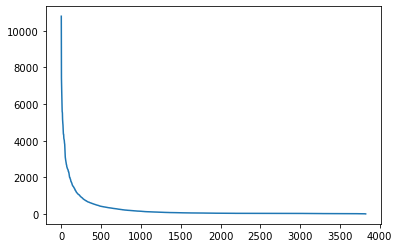

In [26]:
lengths = [len(el) for el in batch_cat]
plt.plot(lengths)

In [24]:
lengths = [len(el) for el in batch_cat_s]
plt.plot(lengths)

NameError: name 'batch_cat_s' is not defined

# Modèle
Pour le modèle, l'auteur s'est inspiré de la solution arrivée 3è à la compétition [Data Science bowl 2019](https://www.kaggle.com/c/data-science-bowl-2019/discussion/127891)  
La procédure de création des embeddings est expliquée, on suppose que l'auteur s'est basé dessus.
## Embeddings
On utilise un embedding catégoriel pour les 3 premières variables et un embedding continu pour les 2 dernières.
Contrairement à la solution du lien ci-dessus on utilise un embedding catégoriel par variable catégorielle plutôt qu'un embedding commun, comme recommandé [ici](https://discuss.pytorch.org/t/categorical-embeddings-can-i-only-have-1-categorical-column-per-embedding-layer/104681/3)

In [27]:
class RiiidEmbedding(nn.Module):
    def __init__(self, maximums, pad_idx=0, emb_size=16, dim=128):
        super().__init__()
        self.emb_size = emb_size
        self.question_emb = nn.Embedding(maximums['question_id']+1, emb_size, padding_idx = pad_idx)
        self.part_emb = nn.Embedding(maximums['part']+1, emb_size, padding_idx = pad_idx)
        self.answer_emb = nn.Embedding(maximums['answered_correctly']+1, emb_size, padding_idx=pad_idx)
        self.cont_emb = nn.Sequential(
            nn.Linear(2, emb_size),
            nn.LayerNorm(emb_size)
            )
        self.merge = nn.Linear(4*emb_size, dim)#, bias=False)

    def forward(self, x_cat, x_cont):
        if len(x_cat.size()) == 2:
            x_cat = x_cat.unsqueeze(0)
            x_cont = x_cont.unsqueeze(0)
        q_emb = self.question_emb(x_cat[:, :, 0])
        p_emb = self.part_emb(x_cat[:, :, 1])
        a_emb = self.answer_emb(x_cat[:, :, 2])
        cont_emb = self.cont_emb(x_cont)
        emb = torch.cat([q_emb, p_emb, a_emb, cont_emb], dim=2)
        emb = self.merge(emb)
        return emb

In [28]:
def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

In [29]:
class LastQueryTransformerEncoderLayer(nn.Module):
    r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
    This standard encoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.

    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> src = torch.rand(10, 32, 512)
        >>> out = encoder_layer(src)
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(LastQueryTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(LastQueryTransformerEncoderLayer, self).__setstate__(state)

    def forward(self, src, src_mask = None, src_key_padding_mask = None):
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        src2 = self.self_attn(src[-1:, :, :], src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2) # scr2's second dimension is broadcasted
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

In [30]:
class Riiid(nn.Module):
    def __init__(self, maximums, pad_idx = 0):
        super(Riiid, self).__init__()
        self.pad_idx = pad_idx
        self.emb = RiiidEmbedding(maximums, pad_idx=pad_idx)
        self.encoder_layer = LastQueryTransformerEncoderLayer(d_model=128, nhead=8)
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.dnn = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            #nn.BatchNorm1d(256),
            nn.Linear(256, 1),
        )
                
    def forward(self, x_cat, x_cont):
        pad_mask = self.make_padding_mask(x_cat).transpose(1, 0)
        x = self.emb(x_cat, x_cont)

        x = x.transpose(1, 0) # pytorch MHA requires input to be S×N×E
        x = self.encoder_layer(x, src_key_padding_mask=pad_mask)
        x = x.transpose(1, 0)
        x = self.lstm(x)[1][0]
        x = self.dnn(x).squeeze(1)
        
        return x 

    def make_padding_mask(self, x_cat):
        pad_mask = (x_cat[:, :, 0] != self.pad_idx).transpose(1, 0)
        return pad_mask


# Training

In [80]:
model = Riiid(maximums).to(device)

In [81]:
LEARNING_RATE = 1e-5
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [82]:
epochs = 20
accuracies = []
losses = []
batch_size = 4
for e in range(epochs):
    e_accuracies = []
    e_losses = []
    print("Epoch ", e)
    for i in range(100):
        x_cat = pad_sequence_left([torch.tensor(el, device=device) for el in batch_cat[e*batch_size:(e+1)*batch_size]], batch_first=True)
        x_cont = pad_sequence_left([torch.tensor(el, dtype=torch.float, device=device) for el in batch_cont[e*batch_size:(e+1)*batch_size]], batch_first=True)
        y = torch.tensor(batch_y[e*batch_size:(e+1)*batch_size], dtype=torch.float, device=device).unsqueeze(1)

        ypred = model(x_cat, x_cont).squeeze(0)
        loss = criterion(ypred, y)
        with torch.no_grad():
            e_losses.append(float(loss))
            e_accuracies.append((torch.round(torch.sigmoid(ypred)) == y).float().mean().item())

        loss.backward()
        optimizer.step()
    losses.append(mean(e_losses))
    accuracies.append(mean(e_accuracies))
    print("Loss:", losses[-1])
    print("Accuracy:", accuracies[-1])

Epoch  0
Loss: nan
Accuracy: 0.0
Epoch  1
Loss: nan
Accuracy: 0.0
Epoch  2
Loss: nan
Accuracy: 0.0
Epoch  3
Loss: nan
Accuracy: 0.0
Epoch  4


KeyboardInterrupt: 

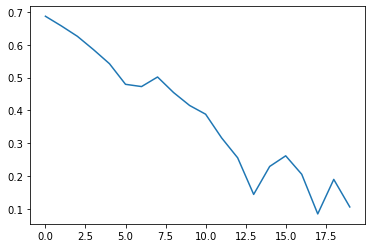

In [32]:
plt.plot(losses)

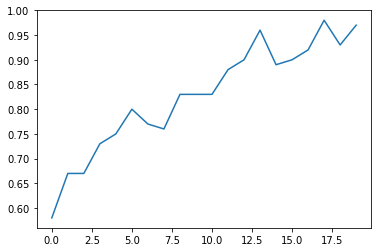

In [34]:
plt.plot(accuracies)

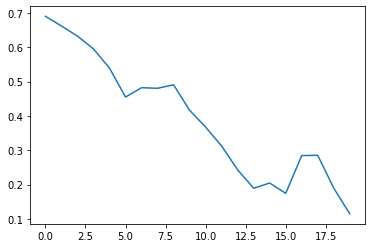

In [95]:
plt.plot(losses)

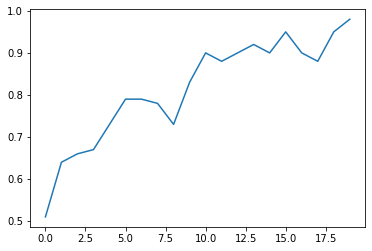

In [96]:
plt.plot(accuracies)

# tests

In [110]:
x_cat, x_cont = batch_cat[0], batch_cont[0]

In [111]:
truc = model.emb(x_cat, x_cont)
truc.shape

torch.Size([1, 46, 128])

In [112]:
truc = model.encoder_layer(truc)
truc.shape

torch.Size([1, 46, 128])

In [113]:
truc = model.lstm(truc)[1][0]
truc.shape

torch.Size([1, 1, 128])

In [118]:
model.dnn(truc).squeeze(1)

tensor([[5.7500]], grad_fn=<SqueezeBackward1>)

In [38]:
yhat = model.dnn(truc)#.shape

In [39]:
batch_y[0]

1

In [58]:
criterion(torch.tensor(batch_y[0], dtype=torch.float).unsqueeze(0), torch.tensor([1], dtype=torch.float))

tensor(0.3133)

In [85]:
criterion(torch.tensor([0.7, .99]), torch.tensor([1., 1.]))

tensor(0.1834)

In [78]:
criterion.weight